In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Path to the Africa station list
AFRICA_LIST = "/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/aeronet_stations_africa_2021_2025.txt"

# Directory where station files are stored

LEV1_DIR='//glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/AOD_Level15_All_Points_V3/AOD/AOD15/ALL_POINTS/'
LEV2_DIR='/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/AOD_Level2_All_Points_V3/AOD20/ALL_POINTS/'
plots_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/plots/'



In [3]:
def count_unique_days(df,st_year=2021,end_year=2024):
    if df.empty:
        return 0
   
    mask = (df['Date'].dt.year >= st_year) & (df['Date'].dt.year <= end_year)
    return df.loc[mask, 'Date'].dt.date.nunique()

In [58]:
def assign_bin(date):
    for label, upper, color, marker in bins:
        if pd.isnull(date):
            return 'Unknown', 'gray', 'x'
        if date < upper:
            return label, color, marker
    return 'Unknown', 'gray', 'x'


In [4]:
# Apply the interpolation function to each rown seperately
def quadratic_interp_loglog(x, y, x0):
    # Same as above, but in log-log space
    lx = np.log(x)
    ly = np.log(y)
    lx0 = np.log(x0)
    # Set up the system
    x1, x2, x3 = lx
    y1, y2, y3 = ly
    A = np.array([
        [x1**2, x1, 1],
        [x2**2, x2, 1],
        [x3**2, x3, 1]
    ])
    b = np.array([y1, y2, y3])
    a, b_, c = np.linalg.solve(A, b)
    logy0 = a*lx0**2 + b_*lx0 + c
    return np.exp(logy0)



def interpolateAOD550_new(row):
    x = np.array([0.440, 0.500, 0.675])
    arr_aod550=[]
    aod440=row['AOD_440nm'][0].reset_index(drop=True)
    aod500=row['AOD_500nm'][0].reset_index(drop=True)
    aod675=row['AOD_675nm'][0].reset_index(drop=True)

    for i in range(0,len(row['AOD_440nm'][0])):
        
        # y=np.array([row['AOD_440nm'][0][i], row['AOD_500nm'][0][i], row['AOD_675nm'][0][i]])
        y=np.array([aod440[i], aod500[i], aod675[i]])
        
        if (not np.isnan(y).any()) and (y.min() > -99):
            i_aod=quadratic_interp_loglog(x, y, 0.550)
        else:
            i_aod = np.nan
        
        arr_aod550.append(i_aod)
    
    return arr_aod550






In [5]:
%%time
# Read the list of African stations
# with open(AFRICA_LIST) as f:
#     data  = [line.strip() for line in f if line.strip()]
    # Extract station names, latitude, longitude, and elevation
stations_df = pd.read_csv(AFRICA_LIST, header=1, names=['station', 'longitude', 'latitude'])
stations_df
summary = []
         


for station in stations_df['station']:
    print(f"Processing station: {station}")
    lev1_file=glob(LEV1_DIR +  '*{}*'.format(station+'.lev15' ))[0]
    lev2_file=glob(LEV2_DIR +  '*{}*'.format(station+'.lev20'))[0]
    # Suppose 'station' is the current station name in your loop
    lat = stations_df.loc[stations_df['station'] == station, 'latitude'].values[0]
    lon = stations_df.loc[stations_df['station'] == station, 'longitude'].values[0]



    
    # Read lev1 data
    if os.path.exists(lev1_file):
        lev1_df =pd.read_csv(lev1_file, skiprows=6, delimiter=",", engine="python",  encoding="ISO-8859-1")
        lev1_count = len(lev1_df)
        lev1_start = lev1_df['Date(dd:mm:yyyy)'].min() if lev1_count > 0 else None
        lev1_end = lev1_df['Date(dd:mm:yyyy)'].max() if lev1_count > 0 else None
        lev1_df['Date'] = pd.to_datetime(lev1_df['Date(dd:mm:yyyy)'], format='%d:%m:%Y', errors='coerce')
    else:
        lev1_count = 0
        lev1_start = None
        lev1_end = None

    # Read lev2 data
    if os.path.exists(lev2_file):
        lev2_df = pd.read_csv(lev2_file, skiprows=6, delimiter=",", engine="python",  encoding="ISO-8859-1")
        lev2_count = len(lev2_df)
        lev2_start = lev2_df['Date(dd:mm:yyyy)'].min() if lev2_count > 0 else None
        lev2_end = lev2_df['Date(dd:mm:yyyy)'].max() if lev2_count > 0 else None
        # for date after 2020 store the following columns
        lev2_df['Date'] = pd.to_datetime(lev2_df['Date(dd:mm:yyyy)'], format='%d:%m:%Y', errors='coerce')
    
        lev2_df_post2020 = lev2_df[lev2_df['Date'].dt.year > 2020]
        AE_values=lev2_df_post2020['440-870_Angstrom_Exponent'] 
        AOD_440nm=lev2_df_post2020['AOD_440nm'] 
        AOD_675nm=lev2_df_post2020['AOD_675nm']
        AOD_500nm=lev2_df_post2020['AOD_500nm'] 
        AE_date=lev2_df_post2020['Date']
        
    else:
        lev2_count = 0
        lev2_start = None
        lev2_end = None
        AE_values=None
        AOD_440nm=None
        AOD_675nm=None
        AOD_500nm=None

    # Use the earliest start and latest end from both levels
    all_starts = [d for d in [lev1_start, lev2_start] if d is not None]
    all_ends = [d for d in [lev1_end, lev2_end] if d is not None]
    start_date = min(all_starts) if all_starts else None
    end_date = max(all_ends) if all_ends else None

    # Inside your station loop:
    lev1_days = count_unique_days(lev1_df)
    lev2_days = count_unique_days(lev2_df)

    lev1_days_st2020 = count_unique_days(lev1_df,2020,2024)
    lev2_days_st2020 = count_unique_days(lev2_df,2020,2024)

    #exclude if the end date is before 2021
    if pd.to_datetime(end_date, format='%d:%m:%Y') < pd.to_datetime('2020-01-01'):
        continue
    summary.append({
        'Station': station,
        'latitude': lat,
        'longitude': lon,
        'Start_Date': start_date,
        'End_Date': end_date,
        'lev1_Count': lev1_count,
        'lev2_Count': lev2_count,
        'lev1_unique_days_2021_2024': lev1_days,
        'lev2_unique_days_2021_2024': lev2_days,
        'lev1_unique_days_2020_2024': lev1_days_st2020,
        'lev2_unique_days_2020_2024': lev2_days_st2020,
        'AE_values': AE_values,
        'AOD_440nm': AOD_440nm,
        'AOD_675nm': AOD_675nm,
        'AOD_500nm': AOD_500nm,
        'AE_date': AE_date
        
    })

summary_df = pd.DataFrame(summary)
summary_df

Processing station: Ilorin
Processing station: Skukuza
Processing station: Maun_Tower
Processing station: IER_Cinzana
Processing station: Saada
Processing station: Cairo_EMA
Processing station: ICIPE-Mbita
Processing station: Tamanrasset_INM
Processing station: Zinder_Airport
Processing station: Bambey-ISRA
Processing station: Henties_Bay
Processing station: Cairo_EMA_2
Processing station: Bujumbura
Processing station: Mongu_Inn
Processing station: SEGC_Lope_Gabon
Processing station: Gobabeb
Processing station: Medenine-IRA
Processing station: Durban_UKZN
Processing station: Upington
Processing station: Koforidua_ANUC
Processing station: Windpoort
Processing station: HESS
Processing station: Lubango
Processing station: Namibe
Processing station: CATUC_Bamenda
Processing station: LAMTO-STATION
Processing station: Sakeji_School
Processing station: Misamfu
Processing station: ASI_Malindi
Processing station: UEM_Maputo
Processing station: Niassa
Processing station: Dakar_Belair
Processing 

,Station,latitude,longitude,Start_Date,End_Date,lev1_Count,lev2_Count,lev1_unique_days_2021_2024,lev2_unique_days_2021_2024,lev1_unique_days_2020_2024,lev2_unique_days_2020_2024,AE_values,AOD_440nm,AOD_675nm,AOD_500nm,AE_date
0,Ilorin,8.320000,4.340000,01:01:1999,31:12:2024,161807,151461,959,753,1216,1010,116650 1.047165 116651 1.050702 116652 ...,116650 0.764915 116651 0.757601 116652 ...,116650 0.484206 116651 0.478539 116652 ...,116650 0.669870 116651 0.660066 116652 ...,116650 2021-01-01 116651 2021-01-01 116652...
1,Skukuza,-24.991700,31.587500,01:01:1999,31:12:2024,180985,160385,966,741,1273,1048,119749 0.916179 119750 0.811997 119751 ...,119749 0.059087 119750 0.065308 119751 ...,119749 0.035671 119750 0.041305 119751 ...,119749 0.053023 119750 0.057784 119751 ...,119749 2021-01-21 119750 2021-01-21 119751...
2,Maun_Tower,-19.900000,23.550000,01:01:2018,31:12:2022,143359,133850,754,624,1007,877,95966 1.150018 95967 1.269821 95968 ...,95966 0.150117 95967 0.191557 95968 ...,95966 0.086627 95967 0.106897 95968 ...,95966 0.130412 95967 0.164952 95968 ...,95966 2021-01-03 95967 2021-01-03 95968 ...
3,IER_Cinzana,13.278433,-5.933867,01:01:2005,31:12:2021,162195,157083,885,818,1035,968,127374 0.393618 127375 0.093565 127376 ...,127374 0.129344 127375 0.083039 127376 ...,127374 0.109245 127375 0.064234 127376 ...,127374 -999.000000 127375 -999.000000 1273...,127374 2021-01-01 127375 2021-01-01 127376...
4,Saada,31.625830,-8.155830,01:01:2005,31:12:2023,167705,152951,476,429,759,712,139204 1.022443 139205 1.018147 139206 ...,139204 0.071626 139205 0.069976 139206 ...,139204 0.046294 139205 0.045479 139206 ...,139204 0.064849 139205 0.063747 139206 ...,139204 2021-01-01 139205 2021-01-01 139206...
5,ICIPE-Mbita,-0.416700,34.200000,01:01:2007,31:12:2023,95156,79314,741,501,741,501,53668 1.356136 53669 1.344622 53670 1...,53668 0.198679 53669 0.195078 53670 0...,53668 0.107783 53669 0.106587 53670 0...,53668 0.167943 53669 0.165002 53670 0...,53668 2021-09-21 53669 2021-09-21 53670 ...
6,Tamanrasset_INM,22.790000,5.530000,01:01:2007,31:12:2024,227157,192751,1243,863,1569,1189,155448 0.591387 155449 0.607913 155450 ...,155448 0.039152 155449 0.037890 155450 ...,155448 0.029939 155449 0.028762 155450 ...,155448 0.036609 155449 0.035371 155450 ...,155448 2021-01-02 155449 2021-01-02 155450...
7,Zinder_Airport,13.776683,8.990233,01:01:2010,31:12:2024,102085,86107,765,303,934,472,75863 0.295281 75864 0.283546 75865 0...,75863 0.059763 75864 0.060004 75865 0...,75863 0.051928 75864 0.053208 75865 0...,75863 -999.000000 75864 -999.000000 75865 ...,75863 2021-01-02 75864 2021-01-02 75865 ...
8,Bambey-ISRA,14.708567,-16.476733,01:01:2011,31:12:2024,16610,7317,189,0,189,0,"Series([], Name: 440-870_Angstrom_Exponent, dt...","Series([], Name: AOD_440nm, dtype: float64)","Series([], Name: AOD_675nm, dtype: float64)","Series([], Name: AOD_500nm, dtype: float64)","Series([], Name: Date, dtype: datetime64[ns])"
9,Cairo_EMA_2,30.080767,31.290067,01:01:2011,31:12:2024,117719,104455,1232,851,1232,851,79542 0.100095 79543 0.165069 79544 ...,79542 0.169579 79543 0.175423 79544 ...,79542 0.158433 79543 0.158364 79544 ...,79542 0.165033 79543 0.168765 79544 ...,79542 2021-01-14 79543 2021-01-14 79544 ...


In [ ]:
def clean_ae(ae,ae_date,aod):
    # Ensure both arrays exist and are the same length
    # ae = row['AE_values']
    # ae_date=row['AE_date']
    # aod = row['AOD_550nm']
    
    if ae is None or aod is None:
        return None
    # Convert to numpy arrays for boolean indexing
    ae = np.array(ae)
    aod = np.array(aod)
    if len(ae) != len(aod):
        return None

    # Keep AE where corresponding AOD550 > 0.2
    mask = aod > 0.2
    cleaned_ae=ae[mask].tolist() if np.any(mask) else None
    cleaned_ae_date=ae_date[mask].tolist() if np.any(mask) else None

    ae_arr = np.array(cleaned_ae)
    n_total = len(ae_arr)
    n_coarse = np.sum(ae_arr < 1)
    n_fine = np.sum(ae_arr > 1)
    pct_coarse = 100 * n_coarse / n_total
    pct_fine = 100 * n_fine / n_total
    if pct_coarse >= 80:
        mode= 'coarse'
    elif pct_fine >= 80:
        mode= 'fine'
    else:
        mode= 'mix'

    return cleaned_ae, cleaned_ae_date, mode

In [ ]:
# if the lev2_unique_days_2020_2024 is zero exclude the station
summary_df = summary_df[summary_df['lev2_unique_days_2020_2024'] > 0]
aod_550_series= []
cleaned_ae_series = []
cleaned_ae_date_series = []
mode_series = []
for station in summary_df['Station']:

    print(f"{station}")
    # Extract the row for the current station
    row = summary_df[summary_df['Station'] == station].reset_index(drop=True)

    aod550_values = interpolateAOD550_new(row)
    if np.all(np.isnan(aod550_values)):
    # All values are NaN, handle accordingly
        cleaned_ae = np.nan
        cleaned_ae_date = np.nan
        mode = np.nan
    else:
        cleaned_ae, cleaned_ae_date, mode = clean_ae(row['AE_values'][0],row['AE_date'][0],aod550_values)

    cleaned_ae_series.append(cleaned_ae)
    cleaned_ae_date_series.append(cleaned_ae_date)
    mode_series.append(mode)
    aod_550_series .append(aod550_values)
    # The uncertainty of AE is low at (AOD ∼0.2 or more) (Sayer, 2020)
    # filter all data with aerMean550 > 0.2
    

summary_df['AOD_550nm'] = aod_550_series
summary_df['cleaned_AE'] = cleaned_ae_series
summary_df['cleaned_AE_date'] = cleaned_ae_date_series
summary_df['AE_mode'] = mode_series

# exlcuding the nan in mode #San_Marco_Platform does not provide AOD at 440 nm , 500 , 675 and is not included in the analysis 
summary_df = summary_df[summary_df['AE_mode'].notna()]


Ilorin
here
Skukuza
here
Maun_Tower
here
IER_Cinzana
here
Saada
here
ICIPE-Mbita
here
Tamanrasset_INM
here
Zinder_Airport
here
Cairo_EMA_2
here
Mongu_Inn
here
SEGC_Lope_Gabon
here
Gobabeb
here
Medenine-IRA
here
Durban_UKZN
here
Upington
here
Koforidua_ANUC
here
Windpoort
here
HESS
here
CATUC_Bamenda
here
LAMTO-STATION
here
Sakeji_School
here
Misamfu
here
ASI_Malindi
here
UEM_Maputo
here
Niassa
here
Dakar_Belair
here
Pretoria_CSIR-EC
here
San_Marco_Platform
Metsi
here
AAU_ET
here
AAU_Jackros_ET
here


In [57]:
# ratio of unique days in lev 2 to lev 1
summary_df['lev2_to_lev1_ratio_days'] = round(summary_df['lev2_unique_days_2021_2024'] / summary_df['lev1_unique_days_2021_2024']*100,1)
summary_df['lev2_to_lev1_ratio_data'] = round(summary_df['lev2_Count'] / summary_df['lev1_Count']*100,1)
summary_df['lev2_to_lev1_ratio_days_st2020'] = round(summary_df['lev2_unique_days_2020_2024'] / summary_df['lev1_unique_days_2020_2024']*100,1)
# summary_df['lev2_to_lev1_ratio_data_st2020'] = round(summary_df['lev2_Count'] / summary_df['lev1_Count']*100,1)
summary_df
#save the dataframe to a csv file for further analysis
output_file = '/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/aeronet_africa_summary_2020_2024.csv'
summary_df.to_csv(output_file, index=False)


KeyError: 'Start_Date_dt'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Prepare
colors = {'coarse': 'blue', 'fine': 'red', 'mix': 'green'}
alpha = 0.3
months = np.arange(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Prepare data by month and category
monthly_ae = {'coarse': defaultdict(list), 'fine': defaultdict(list), 'mix': defaultdict(list)}

for idx, row in summary_df.iterrows():
    ae = row['cleaned_AE_440_870']
    dates = row['AE_date']
    if ae is None or dates is None or len(ae) == 0:
        continue
    # Categorize station
    ae_arr = np.array(ae)
    n_total = len(ae_arr)
    n_coarse = np.sum(ae_arr < 1)
    n_fine = np.sum(ae_arr > 1)
    pct_coarse = 100 * n_coarse / n_total
    pct_fine = 100 * n_fine / n_total
    if pct_coarse >= 80:
        cat = 'coarse'
    elif pct_fine >= 80:
        cat = 'fine'
    else:
        cat = 'mix'
    # Add AE values to the correct month and category
    for ae_val, date in zip(ae, dates):
        if pd.isnull(date):
            continue
        month = pd.to_datetime(date).month
        monthly_ae[cat][month].append(ae_val)

# Plot monthly histograms for each category
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, cat in enumerate(['coarse', 'mix', 'fine']):
    ax = axes[i]
    data = [monthly_ae[cat][m] for m in months]
    ax.boxplot(data, positions=months, patch_artist=True,
               boxprops=dict(facecolor=colors[cat], alpha=alpha))
    ax.set_title(f"{cat.capitalize()} Dominant Stations", fontsize=14)
    ax.set_ylabel('AERONET AE')
    ax.set_ylim(0, 2.5)
    ax.grid(True, axis='y')
    ax.set_xticks(months)
    ax.set_xticklabels(month_names)
axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

1099

In [70]:
summary_df[['Station','AE_mode']]



,Station,AE_mode
0,Ilorin,coarse
1,Skukuza,fine
2,Maun_Tower,fine
3,IER_Cinzana,coarse
4,Saada,coarse
5,ICIPE-Mbita,mix
6,Tamanrasset_INM,coarse
7,Zinder_Airport,coarse
9,Cairo_EMA_2,mix
10,Mongu_Inn,fine


summary_df['lev2_unique_days_2021_2024'].sum()/summary_df['lev2_unique_days_2020_2024'].sum()
# Output the total unique days and the average ratio


In [62]:
# Assign each station to a bin with color and marker

summary_df[['Start_Bin', 'Color', 'Marker']] = summary_df['Start_Date_dt'].apply(lambda d: pd.Series(assign_bin(d)))


In [60]:
#exclude zero values
summary_df['Start_Date_dt'] = pd.to_datetime(summary_df['Start_Date'], format='%d:%m:%Y', errors='coerce')
summary_df['End_Date_dt'] = pd.to_datetime(summary_df['End_Date'], format='%d:%m:%Y', errors='coerce')
# Extract month and day as strings (MM-DD)
summary_df['Start_year_Month'] = summary_df['Start_Date_dt'].dt.strftime('%Y-%m')
summary_df['End_year_Month'] = summary_df['End_Date_dt'].dt.strftime('%Y-%m')
#  lat and lon only with 3 decimal places
summary_df['latitude'] = summary_df['latitude'].round(3)
summary_df['longitude'] = summary_df['longitude'].round(3)

summary_df[['Station','latitude','longitude','Start_year_Month','End_year_Month','lev1_unique_days_2020_2024','lev2_unique_days_2020_2024','lev2_to_lev1_ratio_days_st2020']]
#month and day of date only
#the first elemt before : is the date
# Convert to datetime if not already



,Station,latitude,longitude,Start_year_Month,End_year_Month,lev1_unique_days_2020_2024,lev2_unique_days_2020_2024,lev2_to_lev1_ratio_days_st2020
0,Ilorin,8.320,4.340,1999-01,2024-12,1216,1010,83.1
1,Skukuza,-24.992,31.588,1999-01,2024-12,1273,1048,82.3
2,Maun_Tower,-19.900,23.550,2018-01,2022-12,1007,877,87.1
3,IER_Cinzana,13.278,-5.934,2005-01,2021-12,1035,968,93.5
4,Saada,31.626,-8.156,2005-01,2023-12,759,712,93.8
5,ICIPE-Mbita,-0.417,34.200,2007-01,2023-12,741,501,67.6
6,Tamanrasset_INM,22.790,5.530,2007-01,2024-12,1569,1189,75.8
7,Zinder_Airport,13.777,8.990,2010-01,2024-12,934,472,50.5
9,Cairo_EMA_2,30.081,31.290,2011-01,2024-12,1232,851,69.1
10,Mongu_Inn,-15.267,23.134,2016-01,2023-12,1093,733,67.1


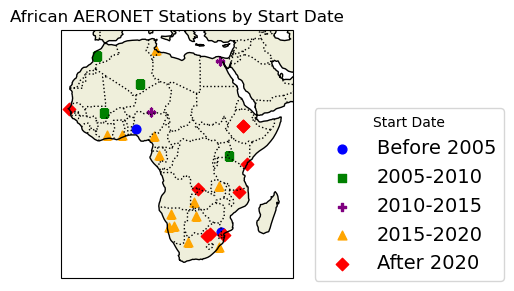

In [63]:


# Define bins and colors for start dates
# Define bins with label, upper date, color, and marker
bins = [
    ('Before 2005', pd.to_datetime('2005-01-01'), 'blue', 'o'),
    ('2005-2010', pd.to_datetime('2010-01-01'), 'green', 's'),
    ('2010-2015', pd.to_datetime('2015-01-01'), 'purple', 'P'),
    ('2015-2020', pd.to_datetime('2020-01-01'), 'orange', '^'),
    ('After 2020', pd.to_datetime('2100-01-01'), 'red', 'D')
]


# Plot
fig = plt.figure(figsize=(3, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot each bin
for label, _, color, marker in bins:
    subset = summary_df[summary_df['Start_Bin'] == label]
    ax.scatter(
        subset['longitude'], subset['latitude'],
        color=color,marker=marker,  label=label, s=40, transform=ccrs.PlateCarree()
    )

# Optionally plot unknowns
unknown = summary_df[summary_df['Start_Bin'] == 'Unknown']
if not unknown.empty:
    ax.scatter(
        unknown['longitude'], unknown['latitude'],
        color='gray',  marker='x',label='Unknown', s=40, edgecolor='k', transform=ccrs.PlateCarree()
    )

plt.legend(title='Start Date', loc='lower left', fontsize=14,bbox_to_anchor=(1.05, -0.05))
plt.title('African AERONET Stations by Start Date')
plt.savefig(plots_dir + 'aeronet_africa_stations_start_date.png', bbox_inches='tight', dpi=300)

In [106]:
# # plot stations on map and text their name
# plt.figure(figsize=(10, 16))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_title('African AERONET Stations', fontsize=14)
# ax.scatter(
#     summary_df['longitude'], summary_df['latitude'],
#     color='black', marker='o', s=10, transform=ccrs.PlateCarree()
# )
# # Annotate each station with its name
# for i, row in summary_df.iterrows():
#     ax.text(row['longitude'], row['latitude'], row['Station'], c='r', fontsize=8, ha='right', transform=ccrs.PlateCarree())
# plt.show()

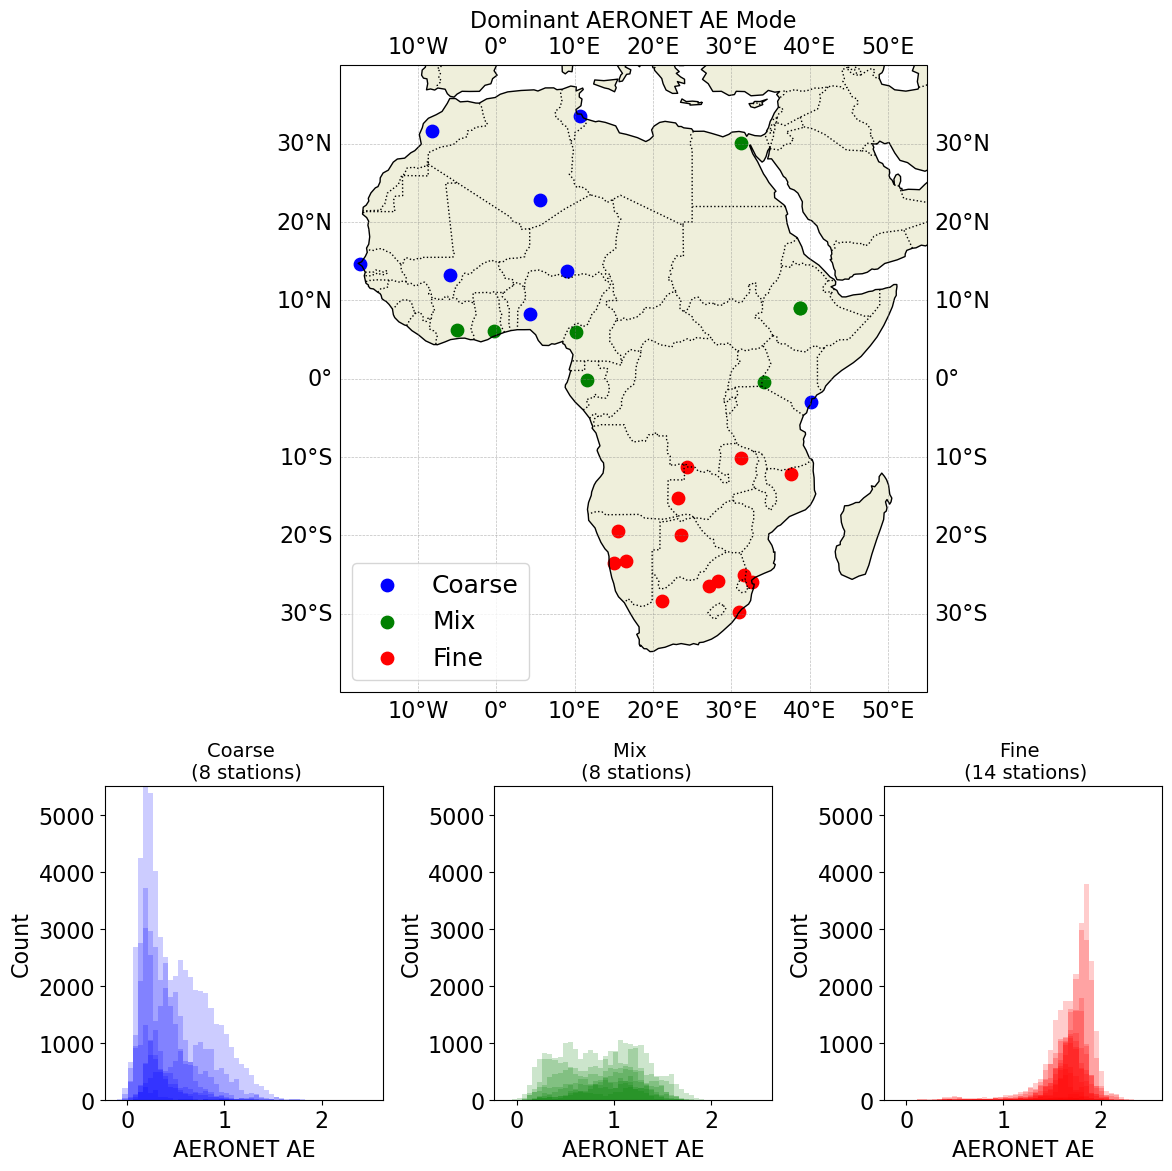

In [136]:
# Prepare
colors = {'coarse': 'blue', 'fine': 'red', 'mix': 'green'}
alpha = 0.3
months = np.arange(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bins = [
    ('Before 2005', pd.to_datetime('2005-01-01'), 'blue', 'o'),
    ('2005-2010', pd.to_datetime('2010-01-01'), 'green', 's'),
    ('2010-2015', pd.to_datetime('2015-01-01'), 'purple', 'P'),
    ('2015-2020', pd.to_datetime('2020-01-01'), 'orange', '^'),
    ('After 2020', pd.to_datetime('2100-01-01'), 'red', 'D')
]


plt.rc('font', size=16)
# --- Figure and axes ---
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 3, height_ratios=[2, 1])


# Top row: two maps, each spanning 1.5 columns
# ax1 = fig.add_subplot(gs[0, 0:2], projection=ccrs.PlateCarree())  # columns 0 and 1
ax2 = fig.add_subplot(gs[0, 0:3], projection=ccrs.PlateCarree())  # column 2

# ax1.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())
# ax1.add_feature(cfeature.LAND)
# ax1.add_feature(cfeature.COASTLINE)
# ax1.add_feature(cfeature.BORDERS, linestyle=':')
# for label, _, color, marker in bins:
#     subset = summary_df[summary_df['Start_Bin'] == label]
#     ax1.scatter(subset['longitude'], subset['latitude'], color=color, marker=marker, label=label, s=40, transform=ccrs.PlateCarree())
# ax1.set_title('Station Start Date')
# ax1.legend(fontsize=10, loc='lower left')

# --- 2. Map: Mode ---
# ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax2.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
for mode in ['coarse', 'mix', 'fine']:
    subset = summary_df[summary_df['AE_mode'] == mode]
    ax2.scatter(subset['longitude'], subset['latitude'], color=colors[mode], marker='o', label=mode.capitalize(), s=80, transform=ccrs.PlateCarree())
ax2.set_title('Dominant AERONET AE Mode', fontsize=16)
ax2.legend(fontsize=18, loc='lower left')


ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')

ax_1 = fig.add_subplot(gs[1, 0]) 
ax_2 = fig.add_subplot(gs[1, 1])  
ax_3 = fig.add_subplot(gs[1, 2])


# --- 4-6. Histograms of AE values by mode ---
for station in summary_df['Station']:
    # print(f"Plotting AE values for station: {station}")
    station_data = summary_df[summary_df['Station'] == station]
    if station_data.empty:
        continue
    ae_mode = station_data['AE_mode'].values[0]
    ae_values = station_data['cleaned_AE'].values[0]
    if ae_mode== 'coarse':
        ax = ax_1
        n_stations = len(summary_df[summary_df['AE_mode'] == 'coarse'])
    elif ae_mode == 'mix':
        ax = ax_2
        n_stations = len(summary_df[summary_df['AE_mode'] == 'mix'])
    elif ae_mode == 'fine':
        ax = ax_3
        n_stations = len(summary_df[summary_df['AE_mode'] == 'fine'])
    if isinstance(ae_values, list) and len(ae_values) > 0:
        ax.hist(ae_values, bins=50, range=(-0.1, 2.5), color=colors[ae_mode], alpha=0.2, label=f"{station} ({ae_mode})")
        ax.set_ylim([0, 5500])
    
    ax.set_title(f"{ae_mode.capitalize()} "+'\n'+f" ({n_stations} stations)", fontsize=14)
    ax.set_xlabel('AERONET AE')
    ax.set_ylabel('Count')
# for i, mode in enumerate(['coarse', 'mix', 'fine']):
#     ax = fig.add_subplot(gs[1, i])
#     # Flatten AE values for this mode
#     ae_vals = [v for sublist in summary_df[summary_df['AE_mode'] == mode]['cleaned_AE'] if isinstance(sublist, list) for v in sublist]
#     ax.hist(ae_vals, bins=20, color=colors[mode], alpha=0.1)
    # ax.set_title(f"{mode.capitalize()} Stations (n={len(ae_vals)})")
    # ax.set_xlabel('AERONET AE')
    # ax.set_ylabel('Count')
    # ax.set_xlim(0, 2.5)
    # ax.grid(True, axis='y')

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.4)
plt.show()
fig.savefig(plots_dir + '2020_2024_aeronet_africa_stations_mode.png', bbox_inches='tight', dpi=300)

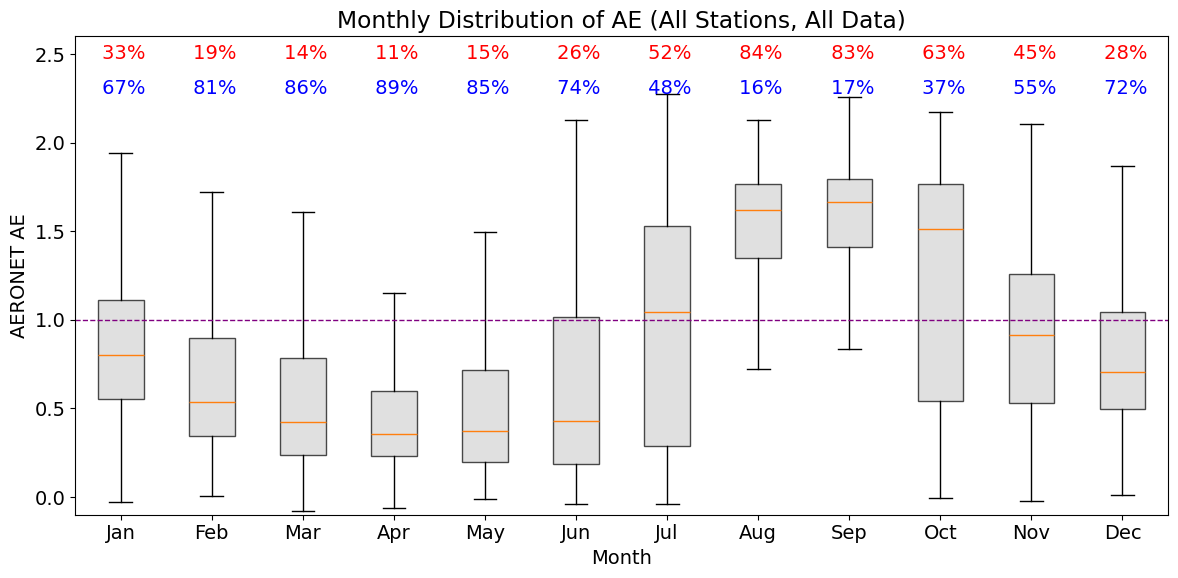

In [166]:
# Now plotting monthly AE: combine all data together, on top of each month shows the percentage of AE >1 (fine particles) vs AE <1 (coarse particles)
plt.rc('font', size=14)

# Gather all AE and date values
all_ae = []
all_dates = []
for idx, row in summary_df.iterrows():
    if row['cleaned_AE'] is not None and row['cleaned_AE_date'] is not None:
        all_ae.extend(row['cleaned_AE'])
        all_dates.extend(row['cleaned_AE_date'])

all_ae = np.array(all_ae)
all_dates = pd.to_datetime(all_dates)

# Prepare monthly bins
months = np.arange(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_ae = {m: [] for m in months}

for ae, date in zip(all_ae, all_dates):
    if pd.isnull(date):
        continue
    monthly_ae[date.month].append(ae)

# Calculate percentages for each month
pct_fine = []
pct_coarse = []
for m in months:
    vals = np.array(monthly_ae[m])
    if len(vals) == 0:
        pct_fine.append(0)
        pct_coarse.append(0)
    else:
        pct_fine.append(100 * np.sum(vals > 1) / len(vals))
        pct_coarse.append(100 * np.sum(vals < 1) / len(vals))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot([monthly_ae[m] for m in months], positions=months, patch_artist=True,
           boxprops=dict(facecolor='lightgray', alpha=0.7),showfliers=False)
ax.set_xticks(months)
ax.set_xticklabels(month_names)
ax.set_ylabel('AERONET AE')
ax.set_xlabel('Month')
ax.set_title('Monthly Distribution of AE (All Stations, All Data)')

# Annotate with percentages
for m, (fine, coarse) in enumerate(zip(pct_fine, pct_coarse), 1):
    ax.text(m, 2.45, f' {fine:.0f}%', ha='center', va='bottom', color='red', fontsize=14)
    ax.text(m, 2.25, f' {coarse:.0f}%', ha='center', va='bottom', color='blue', fontsize=14)

ax.set_ylim(-0.1, 2.6)
ax.axhline(y=1, color='purple', linestyle='--', linewidth=1, label='AE = 1')

plt.tight_layout()
plt.show()
fig.savefig(plots_dir + '2020_2024_aeronet_africa_monthly_ae_boxplot.png', bbox_inches='tight', dpi=300)


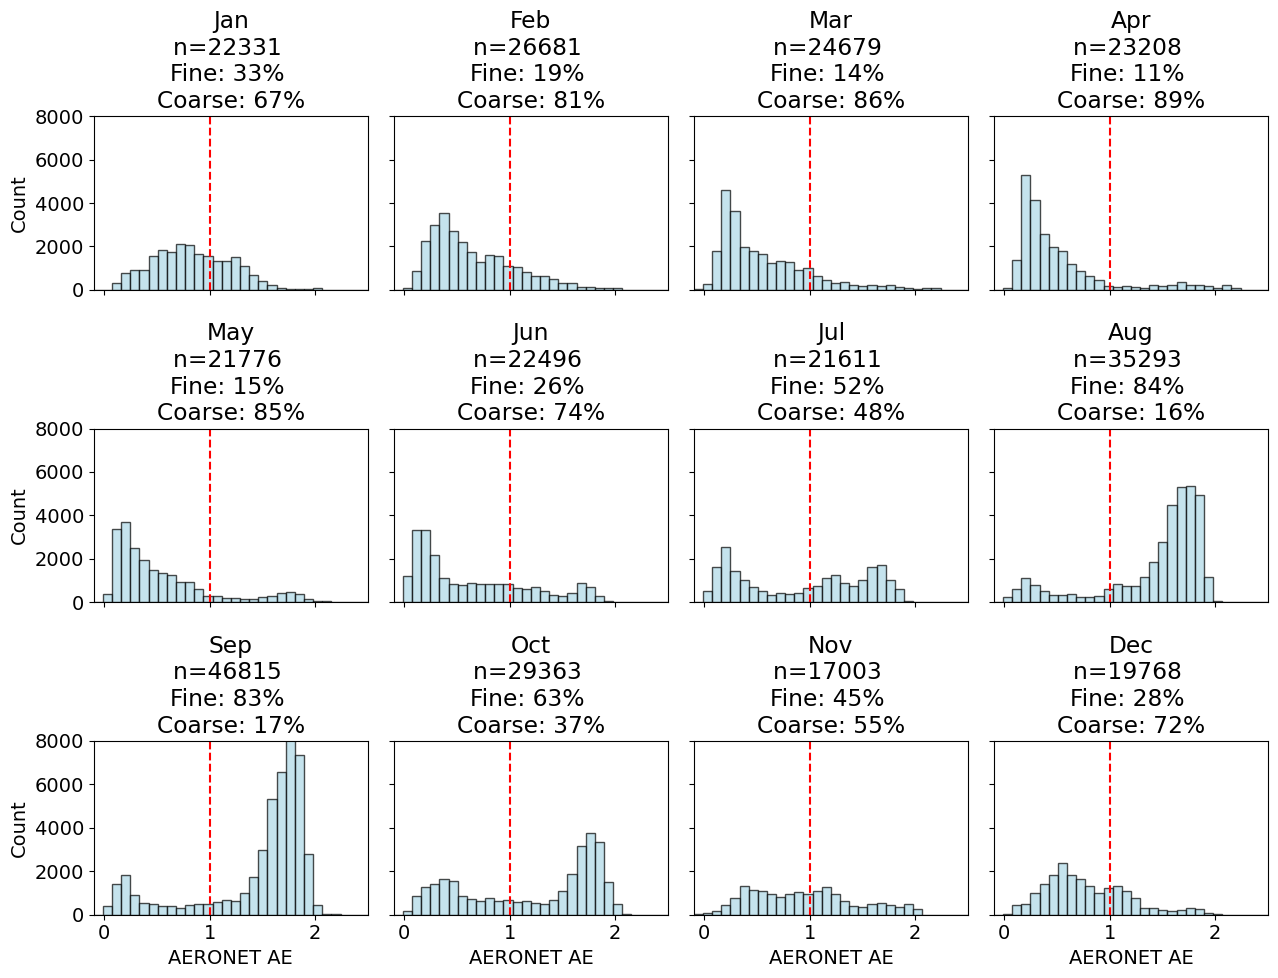

In [ ]:
plt.rc('font', size=14)

# Gather all AE and date values
all_ae = []
all_dates = []
for idx, row in summary_df.iterrows():
    if row['cleaned_AE'] is not None and row['cleaned_AE_date'] is not None:
        all_ae.extend(row['cleaned_AE'])
        all_dates.extend(row['cleaned_AE_date'])

all_ae = np.array(all_ae)
all_dates = pd.to_datetime(all_dates)

months = np.arange(1, 13)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Prepare AE data for each month
monthly_ae = {m: [] for m in months}
for ae, date in zip(all_ae, all_dates):
    if pd.isnull(date):
        continue
    monthly_ae[date.month].append(ae)

fig, axes = plt.subplots(3, 4, figsize=(13, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, m in enumerate(months):
    ax = axes[i]
    data = monthly_ae[m]
    if len(data) > 0:
        ax.hist(data, bins=30, range=(-0.1, 2.5), color='lightblue', edgecolor='k', alpha=0.7)
        pct_fine = 100 * np.sum(np.array(data) > 1) / len(data)
        pct_coarse = 100 * np.sum(np.array(data) < 1) / len(data)
    else:
        pct_fine = pct_coarse = 0
    ax.set_title(month_names[i]+'\n'
    +f'n={len(data)} \n'
    +f'Fine: {pct_fine:.0f}% \n'
    +f'Coarse: {pct_coarse:.0f}%')
    ax.set_xlim(-0.1, 2.5)
    ax.set_ylim(0, 8000)
    if i % 4 == 0:
        ax.set_ylabel('Count')
    if i >= 8:
        ax.set_xlabel('AERONET AE')
    ax.axvline(1, color='red', linestyle='--', label='AE = 1')
plt.tight_layout()
plt.show()
fig.savefig(plots_dir + '2020_2024_aeronet_africa_stations_monthly_ae_hist.png', bbox_inches='tight', dpi=300)   

,Month,Total_AE_Measurements,Month_Name
0,1,67638,Jan
1,2,61850,Feb
2,3,69758,Mar
3,4,74508,Apr
4,5,83608,May
5,6,81085,Jun
6,7,81588,Jul
7,8,81298,Aug
8,9,78476,Sep
9,10,66891,Oct


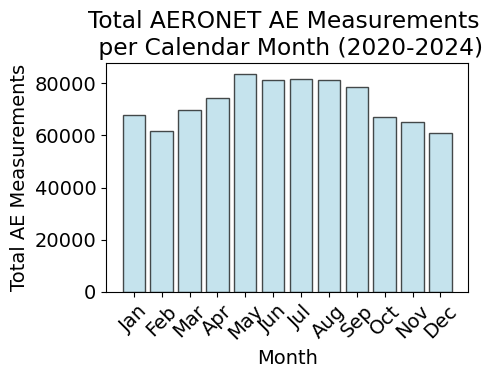

In [158]:
# Sum of all years per month (i.e., total AE measurements for each calendar month across all years)

# all_ae_dates already contains all AE dates (not cleaned)
all_ae_dates = []
for idx, row in summary_df.iterrows():
    if row['AE_date'] is not None:
        all_ae_dates.extend(row['AE_date'])

all_ae_dates = pd.to_datetime(all_ae_dates)
all_ae_dates = all_ae_dates[~pd.isnull(all_ae_dates)]

# Count measurements for each calendar month (Jan, Feb, ..., Dec) summed over all years
ae_monthly_sum = pd.Series(all_ae_dates).dt.month.value_counts().sort_index()
ae_monthly_sum = ae_monthly_sum.rename_axis('Month').reset_index(name='Total_AE_Measurements')

# Add month names for clarity
ae_monthly_sum['Month_Name'] = ae_monthly_sum['Month'].apply(lambda x: ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][x-1])

display(ae_monthly_sum)

#histogram of total AE measurements per month
plt.figure(figsize=(5, 4))
plt.bar(ae_monthly_sum['Month_Name'], ae_monthly_sum['Total_AE_Measurements'], color='lightblue', edgecolor='k', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Total AE Measurements')
plt.title('Total AERONET AE Measurements \n per Calendar Month (2020-2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plots_dir + '2020_2024_total_valid_measure_permonth.png', bbox_inches='tight', dpi=300)